In [1]:
import sys
import os
# Add the 'project' directory to the path
sys.path.append(os.path.abspath('..'))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import pickle
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsRegressor

In [3]:
from project_code.data.load_data import load_col_types, load_data
from project_code.data.prepare_data_sklearn import get_features_targets
from project_code.plotters.infeasibility import infeasibility_flag_to_text

# Loading data and results

## Load data

In [4]:
dataset_name = 'final'
dataset_name += '_taxonomy'
dataset_name += '_ecocodes'

bio_dataset_name = 'biologist_no_pub_age'

# Load the data
dataset_folder = f'../data/processed/'
dfs = load_data(dataset_name=dataset_name, data_split='train_test', datasets_folder=dataset_folder)
col_types = load_col_types(dataset_name=dataset_name, datasets_folder=dataset_folder)
data = get_features_targets(dfs, col_types)

## Load results

In [22]:
results_folder = f'../results/'
feasibility_results_folder = os.path.join(results_folder, 'feasibility')
feas_df_dict = {}
for file in os.listdir(feasibility_results_folder):
    model_name = file.split('_feasibility.csv')[0]
    feas_df_dict[model_name] = pd.read_csv(os.path.join(feasibility_results_folder, file), index_col=0)
    feas_df_dict[model_name]['infeasibility_flag'] = feas_df_dict[model_name]['infeasibility_flag'].astype(str)
    feas_df_dict[model_name]['feasible'] = feas_df_dict[model_name]['feasible'].astype(bool)


print(*feas_df_dict.keys(), sep='\n')

AmP
BijectionMethod
MLP
MultiTaskElasticNet
SRTaxo1NN
Taxo1NN


### Add species where bijection method failed

In [29]:
species_bijection_failed = feas_df_dict['AmP'].index.difference(feas_df_dict['BijectionMethod'].index).values
bijection_failed_df = pd.DataFrame(index=species_bijection_failed, columns=feas_df_dict['BijectionMethod'].columns)
bijection_failed_df['infeasibility_flag'] = 'failed'
bijection_failed_df['feasible'] = False
bijection_failed_df['data_split'] = feas_df_dict['AmP']['data_split']
bijection_failed_df['error_message'] = 'failed'
feas_df_dict['BijectionMethod'] = pd.concat([feas_df_dict['BijectionMethod'], bijection_failed_df])
feas_df_dict['BijectionMethod']

,data_split,feasible,infeasibility_flag,error_message
Abbottina_rivularis,train,True,0,NaN
Ablennes_hians,test,True,0,NaN
Acanthochromis_polyacanthus,train,True,0,NaN
Acanthoclinus_littoreus,train,True,0,NaN
Acanthocybium_solandri,train,True,0,NaN
...,...,...,...,...
Zonotrichia_capensis,train,False,failed,failed
Zonotrichia_leucophrys,train,False,failed,failed
Zonotrichia_querula,train,False,failed,failed
Zosterops_lateralis,train,False,failed,failed


In [6]:
feas_df_dict['AmP'].loc[feas_df_dict['AmP']['infeasibility_flag'] != '0', 'infeasibility_flag']

Series([], Name: infeasibility_flag, dtype: object)

In [30]:
feas_df = pd.concat(feas_df_dict).reset_index(level=0, names='method')
feas_df.replace(to_replace='val', value='train', inplace=True)
feas_df

,method,data_split,feasible,infeasibility_flag,error_message
Abbottina_rivularis,AmP,train,True,0,NaN
Ablennes_hians,AmP,test,True,0,NaN
Abramis_brama,AmP,train,True,0,NaN
Abroscopus_superciliaris,AmP,train,True,0,NaN
Acanthis_flammea,AmP,train,True,0,NaN
...,...,...,...,...,...
Pelophylax_saharicus,Taxo1NN,test,True,0,NaN
Rhinobatos_productus,Taxo1NN,test,True,0,NaN
Zapteryx_brevirostris,Taxo1NN,test,True,0,NaN
Grus_americana,Taxo1NN,test,True,0,NaN


In [42]:
infeasibility_flag_to_text['failed'] = 'Method failed'

In [43]:
feasible_counts = {}
for i, ds in enumerate(['train', 'test']):
    feasible_counts[ds] = feas_df.loc[feas_df['data_split'] == ds, ['method', 'infeasibility_flag']].value_counts().sort_index().reset_index()
    feasible_counts[ds]['infeasibility_flag'] = feasible_counts[ds]['infeasibility_flag'].map(infeasibility_flag_to_text)

In [45]:
feas_df[feas_df['infeasibility_flag'] != '0']['infeasibility_flag'].value_counts()

infeasibility_flag
failed    1357
4          183
1           43
error        4
5            3
6            1
Name: count, dtype: int64

In [46]:
feasible_counts['test'].groupby(['method', 'infeasibility_flag']).sum()

count
method              infeasibility_flag                    
AmP                 Feasible                           355
BijectionMethod     Birth cannot \nbe reached            1
                    Feasible                           142
                    Method failed                      206
                    Non-positive \nparameters            6
MLP                 Feasible                           355
MultiTaskElasticNet Feasible                           355
SRTaxo1NN           Feasible                           338
                    Maturities are not\n increasing     17
Taxo1NN             Feasible                           338
                    Maturities are not\n increasing     17

# Plot results

In [47]:
method_names = {
    'BijectionMethod': 'Bijection Method',
    'Taxo1NN': 'Taxonomic 1-NN',
    'RandomForestRegressor': 'Random Forest',
    'SRTaxo1NN': 'Taxonomic 1-NN',

}

C:\Users\diogo\AppData\Local\Temp\ipykernel_41208\1273015793.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
C:\Users\diogo\AppData\Local\Temp\ipykernel_41208\1273015793.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)


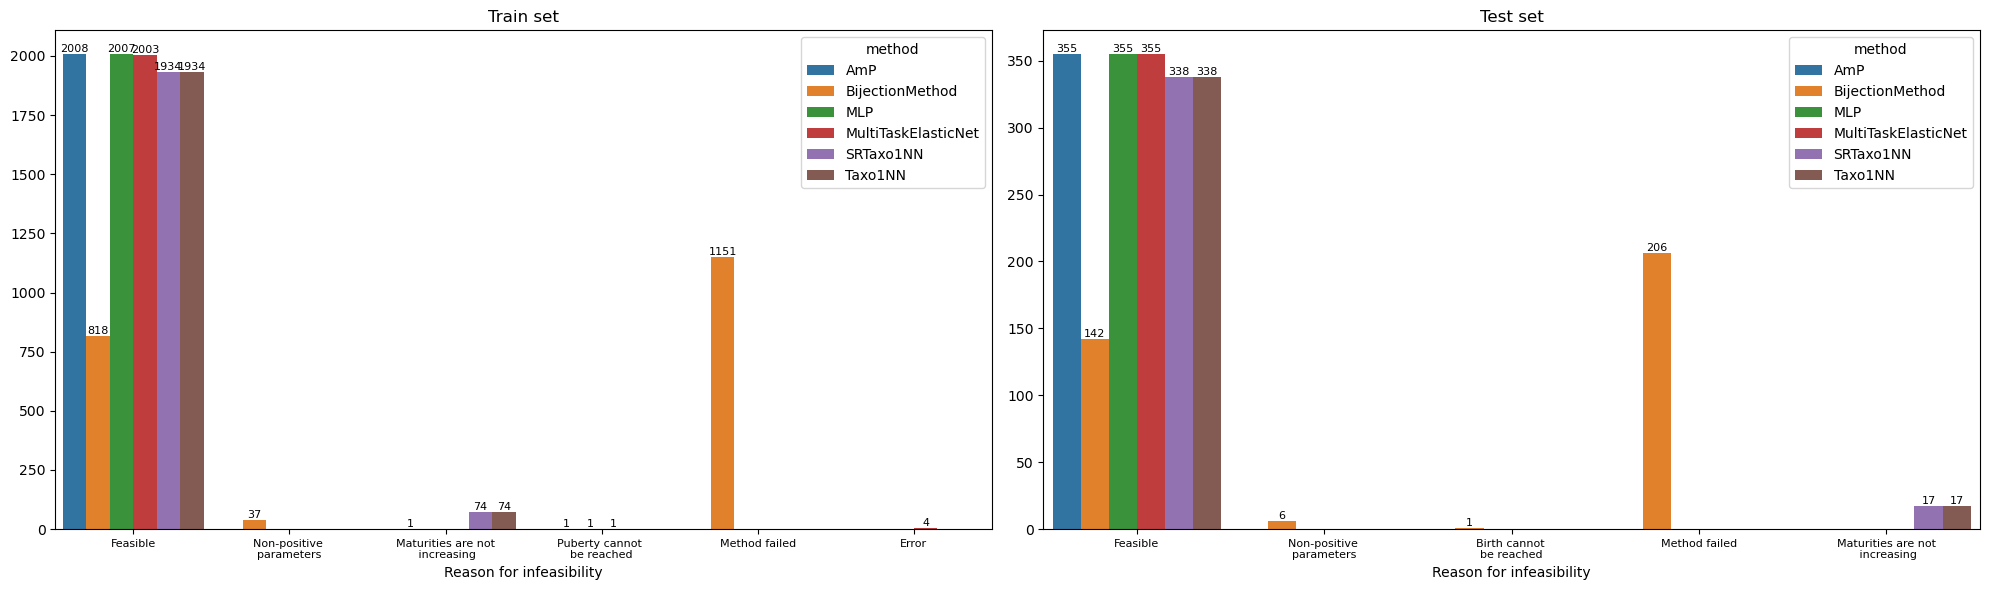

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6), tight_layout=True)
for i, ds in enumerate(['train', 'test']):
    ax = axes[i]
    
    sns.barplot(data=feasible_counts[ds], x='infeasibility_flag', y='count', hue='method', ax=ax,
                width=0.9,)
    ax.set_title(f'{ds.capitalize()} set')
    ax.set_xlabel('Reason for infeasibility')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_ylabel('')
    for j in range(len(feas_df_dict)):
        ax.bar_label(ax.containers[j], fontsize=8)